# Peta laboratorijska vježba - Normalizirajući tokovi

U ovoj laboratorijskoj vježbi koristit ćemo biblioteku normflows koja dopušta jednostavnu implementaciju normalizirajućih tokova. 

Dokumentacija je dostupa na linku -> **https://vincentstimper.github.io/normalizing-flows/**

U ovoj laboratorijskoj vježbi prikazat će se normalizirajući tokovi, generativni modeli bazirani na toku. Generativni modeli bazirani na toku složeni su od niza invertibilnih transformacija. Za razliku od GAN-a i VAE-a eksplicitno uče distribuciju podataka p(x) i zbog toga je njihova funkcija gubitka negativna log vjerojatnost.  

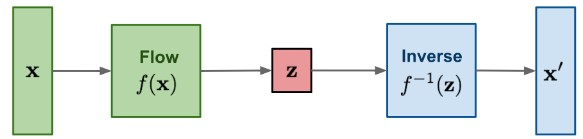

Za razliku od drugih generativnih neuronskih mreža svi slojevi su invertibilni, čime se omogućava mapiranje ulaznih uzoraka *x* u odabranu latentnu distribuciju *p_z(z)*, uobičajno Gaussovu distribuciju. Invertibilno mapiranje podrazumjeva da za svaki uzorak *x*, postoji odgovarajuća latetna distribucija *z* koja omogućava rekonstrukciju bez gubitaka (*z* u *x*). Time se ograničavaju modifikacije u arhitekturi, ali omogućuje NF-ovima da optimiziraju log-vjerojatnost podataka. Treniranje NF-a obično se svodi na maksimiziranje vjerojatnosti podataka za treniranje:

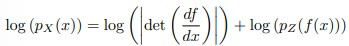

gdje prvi član prikazuje log determinantu Jacobijeve matrice, a drugi gura funkciju *f* prema transformaciji *x* na raspodjelu *p_z*. Moguće je i primjenjivanje više više funkcija sekvencijalno:

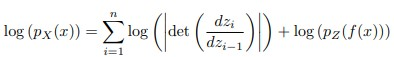

Izračunavanje Jacobievog člana nije uvijek jednostavno, a budući da se često računa postoje mnoga pojednostavljenja kako bi se izbjeglo potpuno računanje matrice. Primjerice, koristeći funkcije *f_i* koje imaju trokutastu Jacobijevu matricu jer rezultat determinante takve matrice su elemenati na dijagonali.
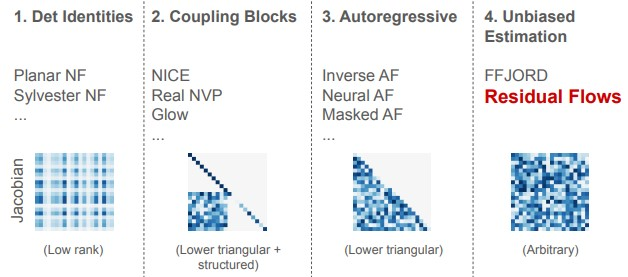

In [78]:
!pip install normflows

In [79]:
import torch
import numpy as np
import normflows as nf
import torchvision
from sklearn.datasets import make_moons
from torch import nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from tqdm import tqdm
import copy

%matplotlib inline

# Residual Flows

Residual Flows (ResFlows) su posebna klasa NFs kako pripadaju free-form Jacobovijevoj matrici. ResFlows koriste f = fL ◦ · · · ◦ f1 za invertibilno mapiranje, gdje je svaki sloj fl
invertibilna rezidualna mreža s Lipschitz ograničenjima konstante κ:

lippp.jpg

gdje je e Lip(g) Lipschitz konstanta funkcije g. 

Napišite argumente Lipschitz multilayer perceptrona tako da je ulaz i izlaz dimenzije 2, a postoji  $hidden\_layers$  slojeva po  $hidden\_units$  neurona po jednom sloju toka. Lipschitzova konsanta neka iznosi 0.9.

In [80]:
def create_residual_nf(num_layers, hidden_units, hidden_layers):
    flows = []
    
    latent_size = 2
    channels = [hidden_units] * hidden_layers
    channels.insert(0, 2)
    channels.append(2)

    for i in range(num_layers):        
        param_map = nf.nets.LipschitzMLP(channels, init_zeros=True, lipschitz_const=0.9)

        flows.append(nf.flows.Residual(param_map, reduce_memory=True, reverse=True))
        flows.append(nf.flows.ActNorm(latent_size))

    q0 = nf.distributions.DiagGaussian(2, trainable=False)

    model = nf.NormalizingFlow(q0=q0, flows=flows)
    
    return model

# Real NVP

Real-valued non-volume preserving (Real NVP) se suočava s visoko nelinearnim modelima u visokodimenzionalnim kontinuiranim prostorima kroz najveću vjerojatnost. Kako bi se optimizirala log-vjerojatnost, uvodi se fleksibilnija arhitektura koja omogućuje izračunavanje logaritamske vjerojatnosti na kontinuiranom podaci. 
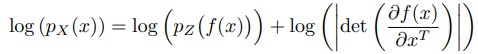

Može se uoćiti da se promjena izvršila prilikom računanja determinante Jacobijeve matrice. Promjena arhitekure nalazi se u "affine coupling layer" blok. Glavna ideja je definirati Jacobijevu matricu kao trokutastu matricu na što jednostavniji način kako bi se efektivno mogla izračunati determinanta. Coupling sloj uključuje jednostavnu operaciju skaliranja i pomaka za neki podskup varijabli u trenutnom sloju, dok drugi dio skupa služi za izračunavanje skaliranja i pomaka. Uz D dimenzionalne ulazne varijable *x*, *y* kao izlaz iz bloka te *d<D*, unaprijedna propagacija računa se izrazom:

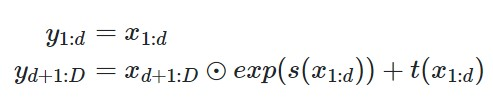

Rezverzna propagacija računa se s izrazom:

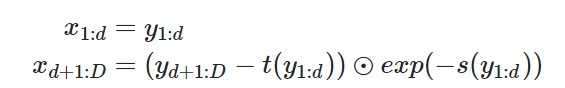

Na sljedećoj slici vizualno su prikazana unaprijedna i reverzna računanja affine coupling sloja.

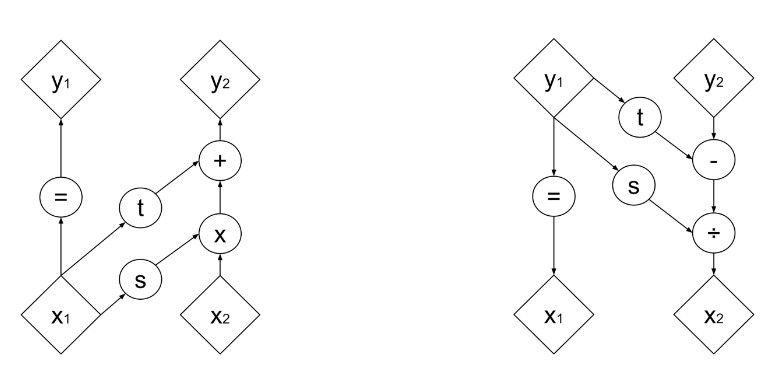

Sada će Jacobijeva matrica poprimiti sljedeći izraz:

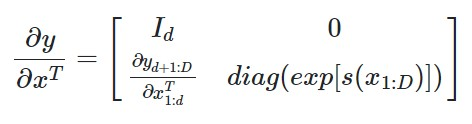
 

https://arxiv.org/abs/1605.08803

Napišite argumente multilayer perceptrona tako da je ulaz dimenzije 1, izlaz dimenzije 2, a  postoji po $hidden\_units$ neurona po jednom sloju toka.

In [81]:
def create_nvp(num_layers, hidden_units):
    flows = []
    
    for i in range(num_layers):
        param_map = nf.nets.MLP([1, hidden_units, 2], init_zeros=True)
        flows.append(nf.flows.AffineCouplingBlock(param_map))
        flows.append(nf.flows.Permute(2, mode='swap'))
    
    q0 = nf.distributions.base.DiagGaussian(2, trainable=False)

    model = nf.NormalizingFlow(q0=q0, flows=flows)
    
    return model

# Podešavanje šuma

Pokretanjem koda iscrtavaju se uzorci iz skupa podataka Make Moons (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html). Crta se $2ˆ20$ uzoraka, sa različitim šumom. Na grafovima šum varira od 0.05 do 0.3 sa pomakom od 0.05. 

Šum je standardom devijacija Gaussovog šuma dodana podacima.


Pitanje: Kako će se ponašati model ako ga učimo na istom skupu podataka, ali sa različitim razinom šuma? Isprobajte treniranje sa dvije vrijednosti šuma (varijabla $NOISE$) i komentirajte rezultate. Dobivene rezultate spremite. 

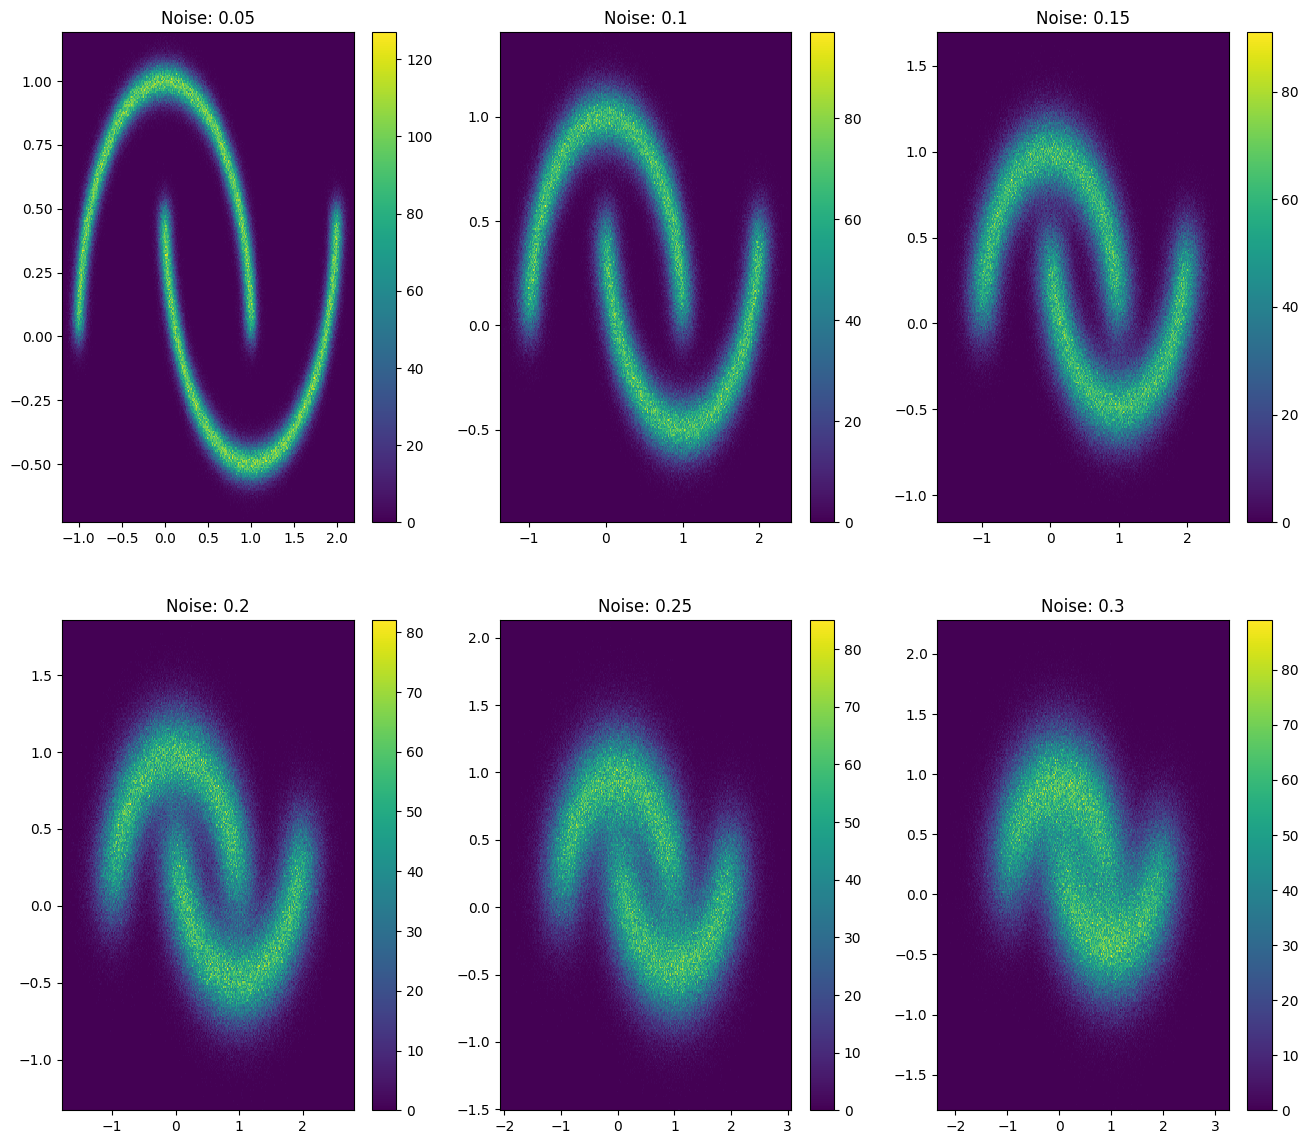

In [82]:
NOISE = 0.1

plt.figure(figsize=(16, 14))


for i, noise in enumerate([0.05, 0.1, 0.15, 0.2, 0.25, 0.3]):
    x_np, _ = make_moons(2 ** 20, noise=noise)
    plt.subplot(2, 3, i + 1)
    plt.hist2d(x_np[:, 0], x_np[:, 1], bins=300)
    plt.colorbar()
    plt.title(f'Noise: {noise}')
plt.show()

In [83]:
grid_size = 100

xx, yy = torch.meshgrid(torch.linspace(-1.5, 2.5, grid_size), torch.linspace(-2, 2, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)

In [84]:
def draw_model_output(model):

    grid_size = 100

    xx, yy = torch.meshgrid(torch.linspace(-1.5, 2.5, grid_size), torch.linspace(-2, 2, grid_size))
    zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
    zz = zz.to(DEVICE)

    model.eval()
    log_prob = model.log_prob(zz).to('cpu').view(grid_size, grid_size)

    model.train()
    prob = torch.exp(log_prob)
    prob[torch.isnan(prob)] = 0

    plt.figure(figsize=(6, 6))
    plt.pcolormesh(xx, yy, prob.data.numpy())
    plt.colorbar()
    plt.show()

Isprobajte oba modela mjenjanjem varijable $model\_type$. Za svaki model isprobajte dvije do tri kombinacije sa brojem slojeva, brojem skrivenih neurona i brojem skrivenih slojeva. Spremite izlaze svi različitih modela nakon treninga, kako bi se mogli vidjeti rezultate na laboratorijskom vježbi.
Prokomentirajte rezultate.

Nacrtani graf prikazuje početni izlaz modela prije treniranja. Ona će se mijenjati tijekom treniranja i pokušati ostvariti distribuciju Make Moonsa.

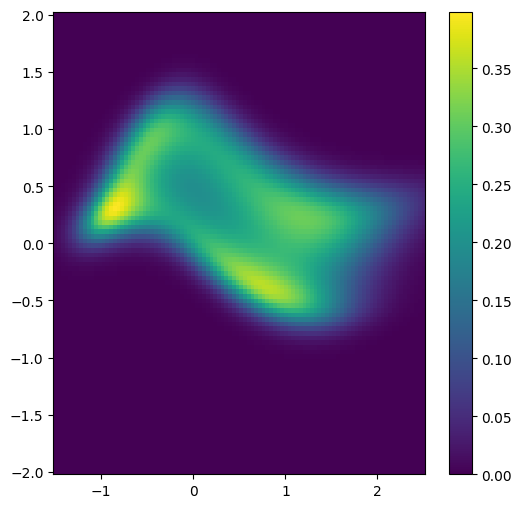

In [106]:
model_type = 'nvp'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

if model_type == 'residual':

    num_layers = 16
    hidden_units = 128
    hidden_layers = 3

    model = create_residual_nf(num_layers=num_layers, hidden_units=hidden_units, hidden_layers=hidden_layers)
    model.to(DEVICE)

if model_type == 'nvp':
    num_layers = 16
    hidden_units = 128

    model_nvp = create_nvp(num_layers=num_layers, hidden_units=hidden_units)
    model_nvp.to(DEVICE)
    
zz = zz.to(DEVICE)

draw_model_output(model)

# Funkcija za treniranje modela

U svakoj epohi uzrukuje se $num\_samples$ uzoraka, te se računa loss preko KL divergencije. Svakih $show\_epoch$ se pokazuje $zz$ izlaz modela koji bi se trebao kroz epohe prilagođavati distribuciji skupa podataka Make Moonsa. Implementirajte da se na kraju treninga vraća model koji je ostvaren nakon cijelog treninga (svih epoha), najbolji model (sa najmanjom vrijednosti funkcije gubitka) i polje sa vrijednostima funkcije gubitka kroz epohe.

Evaluacija modela radi se sa $model.log\_prob(zz)$, te se nad log vjerojatnostima napravi eksponent.  

In [100]:
def train_nf(model, epochs, model_type, optimizer, num_samples=2 ** 9, show_epoch=200):
    loss_array = []
    
    smallest_loss = np.inf
    best_model = None
    model.train()
    
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        
        x_np, _ = make_moons(num_samples, noise=NOISE)
        x = torch.tensor(x_np).float().to(DEVICE)
        
        loss = model.forward_kld(x)
        
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optimizer.step()
        
            loss_array.append(loss.item())
            
            if loss < smallest_loss:
                best_model = model
                
        if model_type == 'residual':
            nf.utils.update_lipschitz(model, 50)
        
        if (epoch + 1) % show_epoch == 0:
            model.eval()
            log_prob = model.log_prob(zz)
            
            model.train()
            prob = torch.exp(log_prob.to('cpu').view(grid_size, grid_size))
            prob[torch.isnan(prob)] = 0

            plt.figure(figsize=(6, 6))
            plt.pcolormesh(xx, yy, prob.data.numpy())
            plt.show()

    return model, best_model, loss_array

 10%|███████▉                                                                       | 499/5000 [01:25<13:24,  5.60it/s]

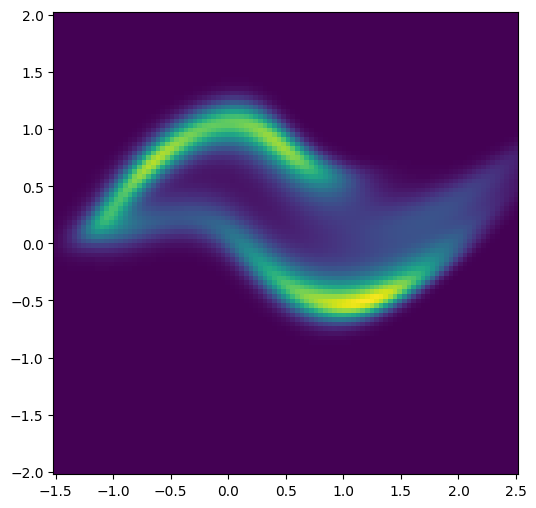

 20%|███████████████▊                                                               | 999/5000 [02:51<10:51,  6.14it/s]

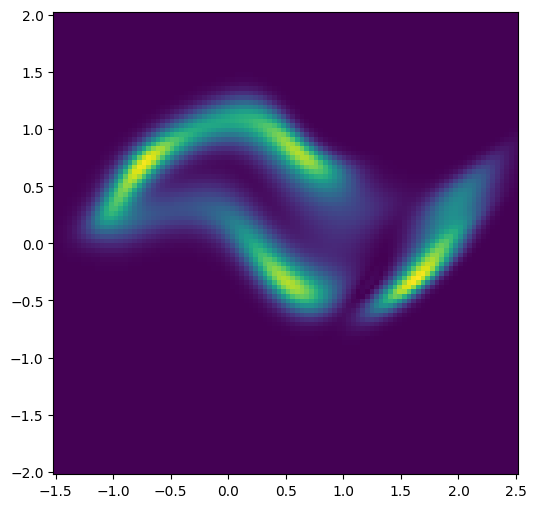

 30%|███████████████████████▍                                                      | 1499/5000 [04:24<10:01,  5.82it/s]

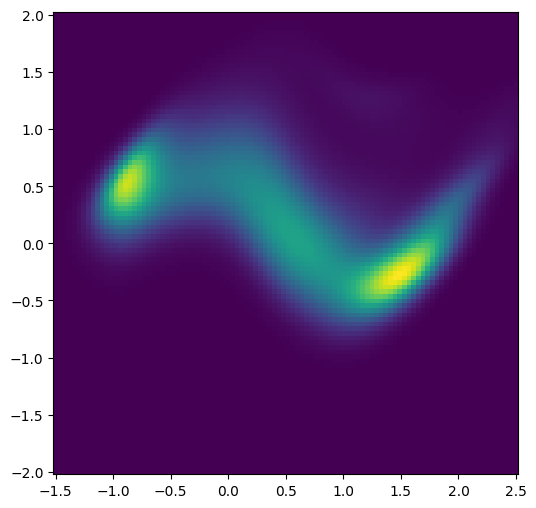

 40%|███████████████████████████████▏                                              | 1999/5000 [05:47<07:56,  6.29it/s]

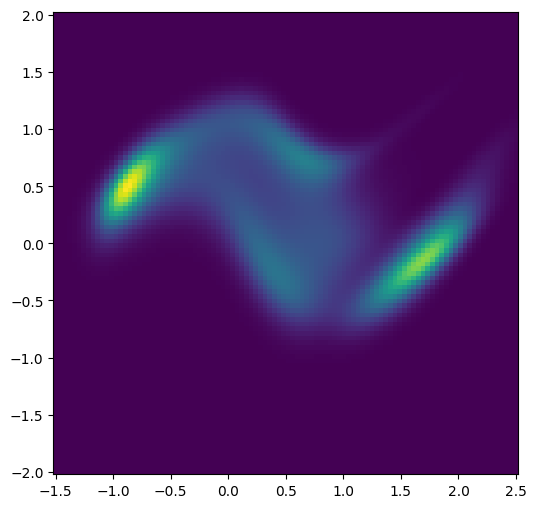

 50%|██████████████████████████████████████▉                                       | 2499/5000 [07:17<06:44,  6.18it/s]

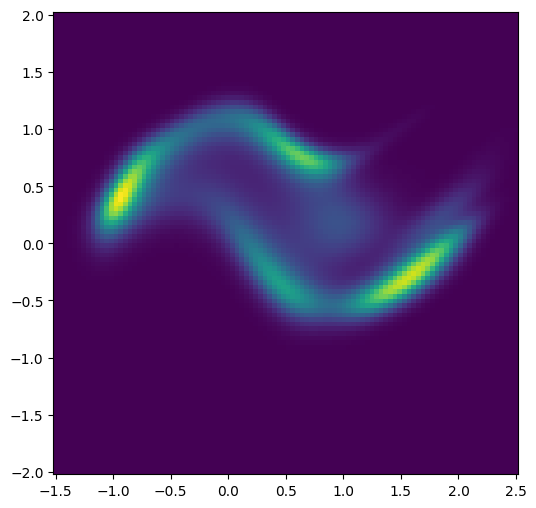

 60%|██████████████████████████████████████████████▊                               | 2999/5000 [08:41<05:42,  5.84it/s]

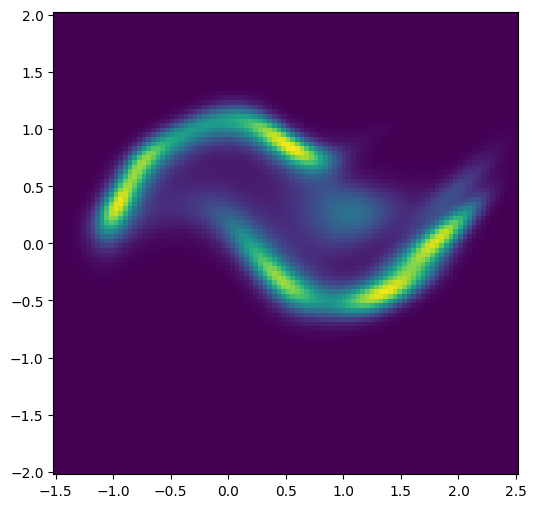

 70%|██████████████████████████████████████████████████████▌                       | 3499/5000 [10:08<04:08,  6.05it/s]

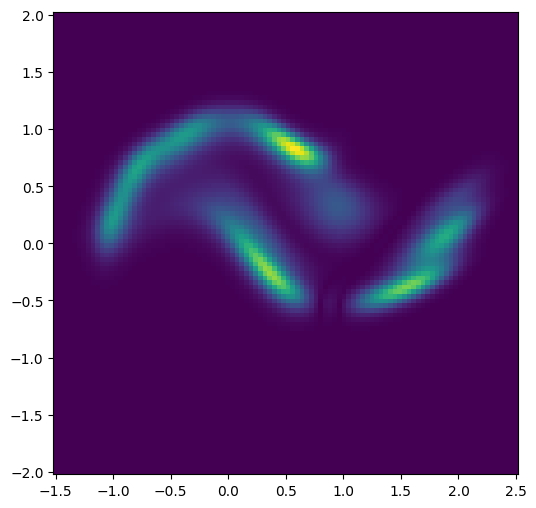

 80%|██████████████████████████████████████████████████████████████▍               | 3999/5000 [11:31<02:49,  5.92it/s]

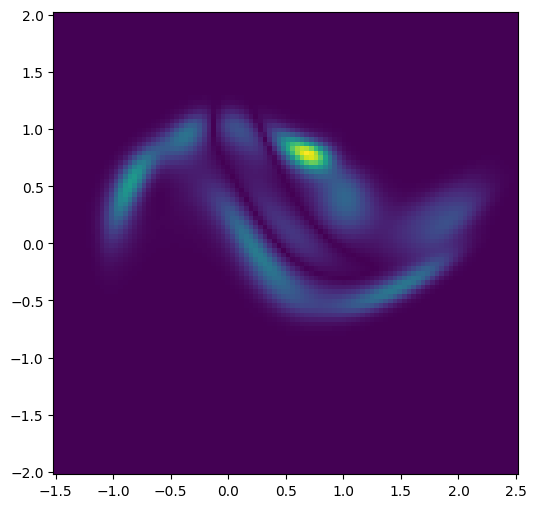

 90%|██████████████████████████████████████████████████████████████████████▏       | 4499/5000 [12:58<01:23,  6.02it/s]

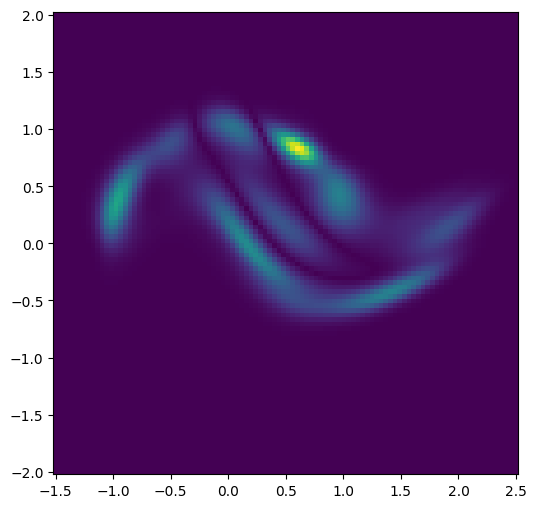

100%|█████████████████████████████████████████████████████████████████████████████▉| 4999/5000 [14:24<00:00,  6.19it/s]

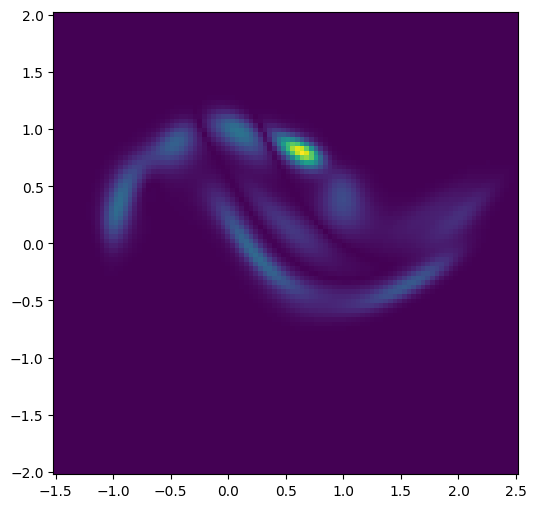

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [14:24<00:00,  5.78it/s]


In [107]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
epochs = 5000
show_epochs = 500

model, best_model, loss_array = train_nf(model, epochs, model_type, optimizer, show_epoch=show_epochs)

### Prokomentirajte izgled funckije gubitka. $loss\_noise$ postavite na vrijednost oko 30, kako bi vam graf bio bez outliera. Ukoliko treba probajte prikaz sa drugom vrijednosti ovisno o outlierima.

Odgovor : 

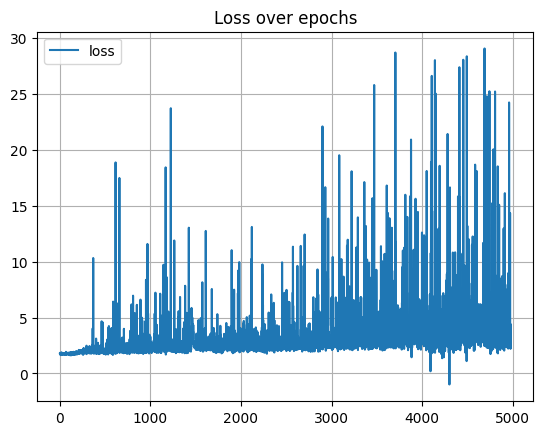

In [108]:
loss_array = np.array(loss_array)

loss_noise = 30

plt.plot(loss_array[loss_array < loss_noise], label='loss')
plt.legend()
plt.grid()
plt.title('Loss over epochs')
plt.show()

### Prokomentirajte razliku između ResidualFlowa i Real NVP modela. Ispišite vrijednost funkcije gubitka za oba modela.

Odgovor: 

Loss for ResidualFlow is 1.5595996379852295


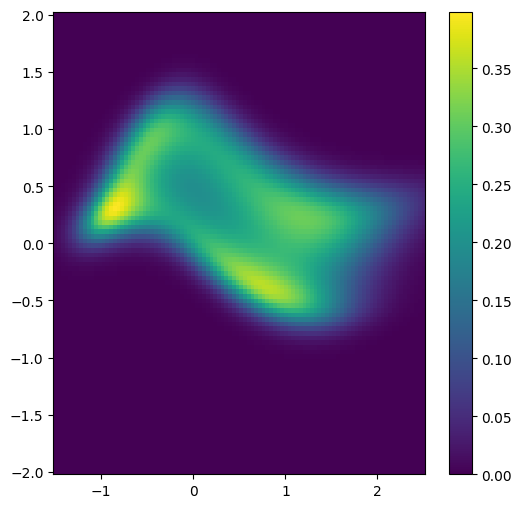

In [105]:
model.eval()
x_np, _ = make_moons(2 ** 9, noise=NOISE)
x = torch.tensor(x_np).float().to(DEVICE)

loss = model.forward_kld(x)

print(f'Loss for ResidualFlow is {loss}')
draw_model_output(model)

In [ ]:
model.eval()
x_np, _ = 
x = torch.tensor(x_np).float().to(DEVICE)

loss = 

print(f'Loss for Real NVP is {loss}')
draw_model_output(model)